# Классификатор LDA для glass.csv

In [482]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import colors

In [483]:
data = pd.read_csv('glass.csv')
data

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


In [484]:
Y = data['Type']
X = data.drop(['Type'], axis=1)

In [485]:
def softmax(X):
    exp_x = np.exp(X - np.max(X))
    return exp_x / exp_x.sum(axis=0)

In [486]:
def plt_probability(classificator, ax):
    nx, ny = 100, 100
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    Z = classificator.predict_probability(np.c_[xx.ravel(), yy.ravel()])
    for i in range(Z.shape[1]):
        Z_ = Z[:, i].reshape(xx.shape)
        ax.pcolormesh(
            xx, yy, Z_, norm=colors.Normalize(0.0, 1.0), zorder=0, alpha=0.3
        )
        ax.contour(xx, yy, Z_, [0.5])

def plt_show(classificator, classificator_predict):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    hue_order = ['admit', 'notadmit', 'border']
    gpa = 'GPA'
    gmat = 'GMAT'

    sns.scatterplot(x=X[gpa], y=X[gmat], hue=Y, hue_order=hue_order, ax=axes[0])
    sns.scatterplot(x=X[gpa], y=X[gmat], hue=classificator_predict, hue_order=hue_order, ax=axes[1])

    axes[0].set_title('Input values')
    axes[1].set_title('Predicted values')

    plt_probability(classificator, axes[0])
    plt_probability(classificator, axes[1])

    plt.show()

In [487]:
class LinearDiscriminantAnalysis:

    def __init__(self):
        self.frequency_classes = None
        self.cov = None
        self.class_name = None
        self.mu_c = None
        self.beta = None
        self.gamma = None

    def fit(self, X, Y):
        self.mu_c = data.groupby([Y.name]).mean()
        X, Y = self.check_data(X, Y)
        self.class_name, count = np.unique(Y, return_counts=True)
        self.frequency_classes = count / count.sum()
        self.cov = self.calculate_cov(X, Y)
        self.beta = np.matmul(np.linalg.inv(self.cov), self.mu_c.T).T
        self.gamma = -(1/2) * np.diag(np.dot(self.mu_c, self.beta.T)) + np.log(self.frequency_classes)

    def check_data(self, X, Y=None):
        if isinstance(X, DataFrame):
            X = X.values
        if isinstance(Y, (DataFrame, Series)):
            Y = Y.values
        return X if Y is None else (X, Y)

    def calculate_cov(self, X, Y):
        cov = np.zeros(shape=(X.shape[1], X.shape[1]))
        for i, cls in enumerate(self.class_name):
            cov += self.frequency_classes[i] * np.cov(X[Y == cls, :].T)
        return cov

    def predict(self, X):
        predicted_values = []
        X = self.check_data(X)
        for x in X:
            mu = np.matmul(self.beta, x.T) + self.gamma
            predicted_values.append(self.class_name[np.argmax(softmax(mu))])
        return predicted_values

    def predict_probability(self, X):
        result = []
        X = self.check_data(X)
        for x in X:
            mu = np.matmul(self.beta, x.T) + self.gamma
            result.append(softmax(mu))
        return np.array(result)

In [488]:
lda = LinearDiscriminantAnalysis()
lda.fit(X,Y)
lda_predict = lda.predict(X)

In [489]:
confusion_matrix(Y, lda_predict)

array([[52, 15,  3,  0,  0,  0],
       [17, 54,  0,  3,  2,  0],
       [11,  6,  0,  0,  0,  0],
       [ 0,  5,  0,  7,  0,  1],
       [ 1,  2,  0,  0,  6,  0],
       [ 1,  2,  0,  1,  0, 25]], dtype=int64)

### Вычисленная confusion matrix для glass.csv

# Классификатор LDA и QDA для admission.csv

In [490]:
data = pd.read_csv('admission.csv')
data

,GPA,GMAT,De
0,2.96,596,admit
1,3.14,473,admit
2,3.22,482,admit
3,3.29,527,admit
4,3.69,505,admit
...,...,...,...
80,3.05,399,border
81,2.85,483,border
82,3.01,453,border
83,3.03,414,border


In [491]:
Y = data['De']
X = data.drop(['De'], axis=1)
classify_points = pd.DataFrame({'GPA':[2.9, 2.5, 3.4], 'GMAT':[400, 515, 487]})
classify_points

,GPA,GMAT
0,2.9,400
1,2.5,515
2,3.4,487


In [492]:
lda = LinearDiscriminantAnalysis()
lda.fit(X,Y)
lda_predict = pd.Series(lda.predict(X), name='De predicted')

In [493]:
confusion_matrix(Y, lda_predict)

array([[28,  3,  0],
       [ 1, 24,  1],
       [ 0,  2, 26]], dtype=int64)

### LinearDiscriminantAnalysis

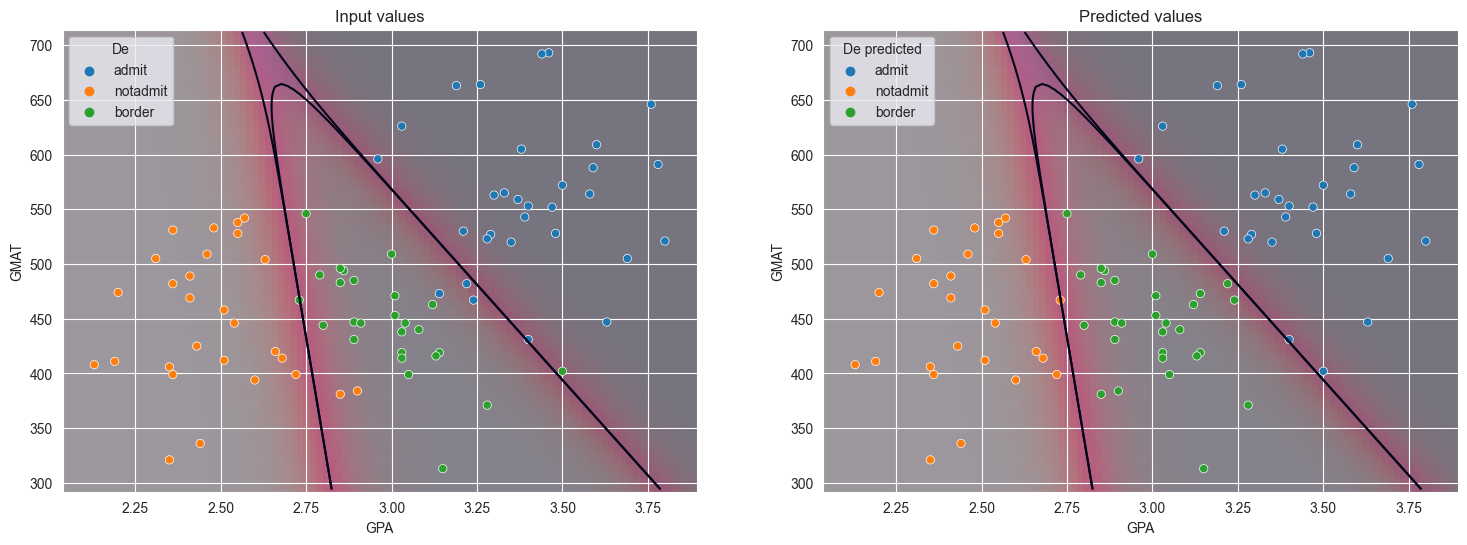

In [494]:
plt_show(lda, lda_predict)

In [495]:
class QuadraticDiscriminantAnalysis:
    def __init__(self):
        self.class_name = None
        self.class_count = None
        self.frequency_classes = None
        self.cov = None
        self.mu_c = None

    def calculate_cov(self, X, Y):
        cov = []
        for cls in self.class_name:
            cov += [np.cov(X[Y == cls, :].T)]
        return cov

    def check_data(self, X, Y=None):
        if isinstance(X, DataFrame):
            X = X.values
        if isinstance(Y, (DataFrame, Series)):
            Y = Y.values
        return X if Y is None else (X, Y)

    def calculate_class_means(self, X, Y):
        means = []
        for cls in self.class_name:
            means.append(np.mean(X[Y == cls, :], axis=0))
        return np.array(means)

    def fit(self, X, Y):
        X, Y = self.check_data(X, Y)
        self.class_name, counts = np.unique(Y, return_counts=True)
        self.frequency_classes = counts / counts.sum()
        self.class_count = self.class_name.shape[0]
        self.cov = self.calculate_cov(X, Y)
        self.mu_c = self.calculate_class_means(X, Y)

    def predict(self, X):
        result = []
        idx = np.argmax(self.predict_probability(X), axis=1)
        for id in idx:
          result.append(self.class_name[id])
        return result

    def predict_probability(self, X):
        result = []
        X = self.check_data(X)
        for x in X:
          probs = []
          for c in range(self.class_count):
            zc = -(1/2)*(x-self.mu_c[c]).T@np.linalg.inv(self.cov[c])@(x-self.mu_c[c])
            prob_c = (self.frequency_classes[c]/np.linalg.norm(2*np.pi*self.cov[c]))*np.exp(zc)
            probs += [prob_c]
          result += [np.array(probs)/np.sum(probs)]

        return np.array(result)

In [496]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X,Y)
qda_predict = pd.Series(qda.predict(X), name='De predicted')

In [497]:
confusion_matrix(Y, qda_predict)

array([[30,  1,  0],
       [ 1, 25,  0],
       [ 0,  1, 27]], dtype=int64)

### QuadraticDiscriminantAnalysis

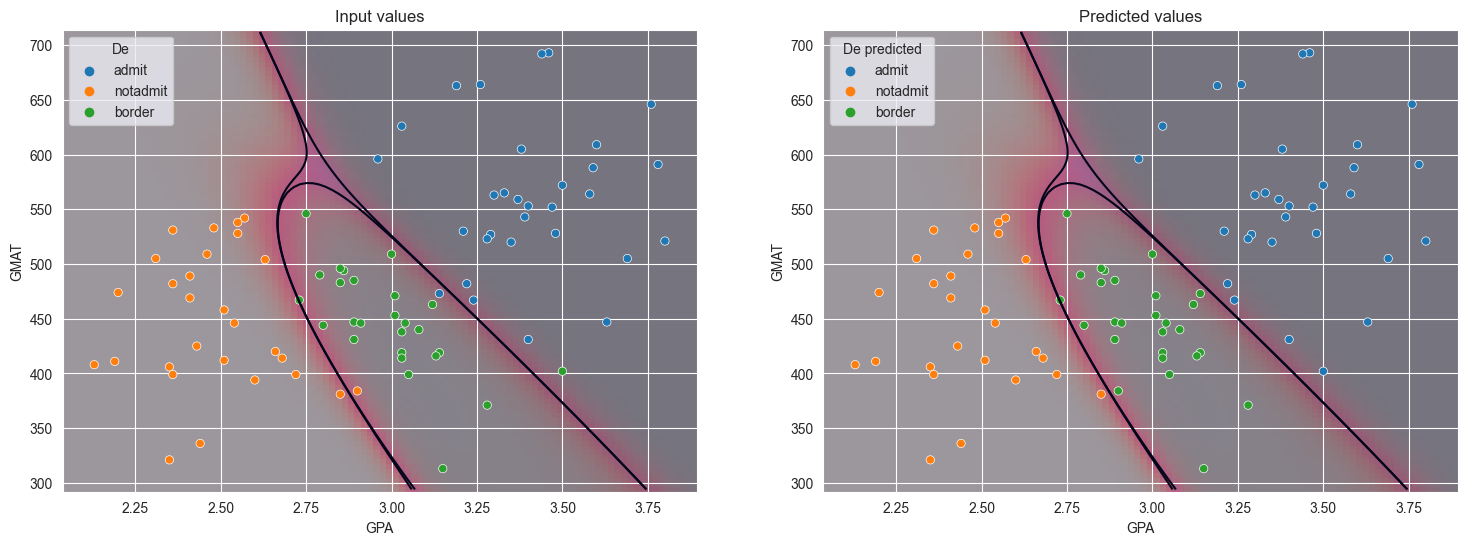

In [498]:
plt_show(qda, qda_predict)

Классификация LDA и QDA тестовых элементов

In [499]:
classify_points['LDA'] = lda.predict(classify_points[['GPA', 'GMAT']])
classify_points['QDA'] = qda.predict(classify_points[['GPA', 'GMAT']])
classify_points

,GPA,GMAT,LDA,QDA
0,2.9,400,border,border
1,2.5,515,notadmit,notadmit
2,3.4,487,admit,admit
